- **Autor:** Jeremy Comino Raigón
- **Curso:** Q1 2023-2024
- **Profesor:** Javier Béjar

# Diagnóstico por la escritura

## Configuración del entorno

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
from apafib import load_darwin
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
df = load_darwin()
df.head(5)
df.shape

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


(174, 452)

Tenemos 174 ejemplos con 452 variables incluyendo la variable objetivo.
A continuación reordenaremos las variables.

In [4]:
columns =list(df.columns)
columns.remove("class")
columns.insert(0,"class")
df = df.reindex(columns=columns)
df.columns

Index(['class', 'ID', 'air_time1', 'disp_index1', 'gmrt_in_air1',
       'gmrt_on_paper1', 'max_x_extension1', 'max_y_extension1',
       'mean_acc_in_air1', 'mean_acc_on_paper1',
       ...
       'mean_gmrt25', 'mean_jerk_in_air25', 'mean_jerk_on_paper25',
       'mean_speed_in_air25', 'mean_speed_on_paper25', 'num_of_pendown25',
       'paper_time25', 'pressure_mean25', 'pressure_var25', 'total_time25'],
      dtype='object', length=452)

A continuación haremos la separación de los datos. En este caso será 30% test y 70% de training. A su vez, viendo el listado de columnas, vemos que ID simplemente es una variable identificadora del paciente. Por lo tanto, a continuación la eliminaremos ya que no aporta información al tema.

In [5]:
df_train, df_test = train_test_split(df,test_size=0.3,random_state=0)
df_train.drop(columns="ID",inplace=True)
df_test.drop(columns="ID",inplace=True)

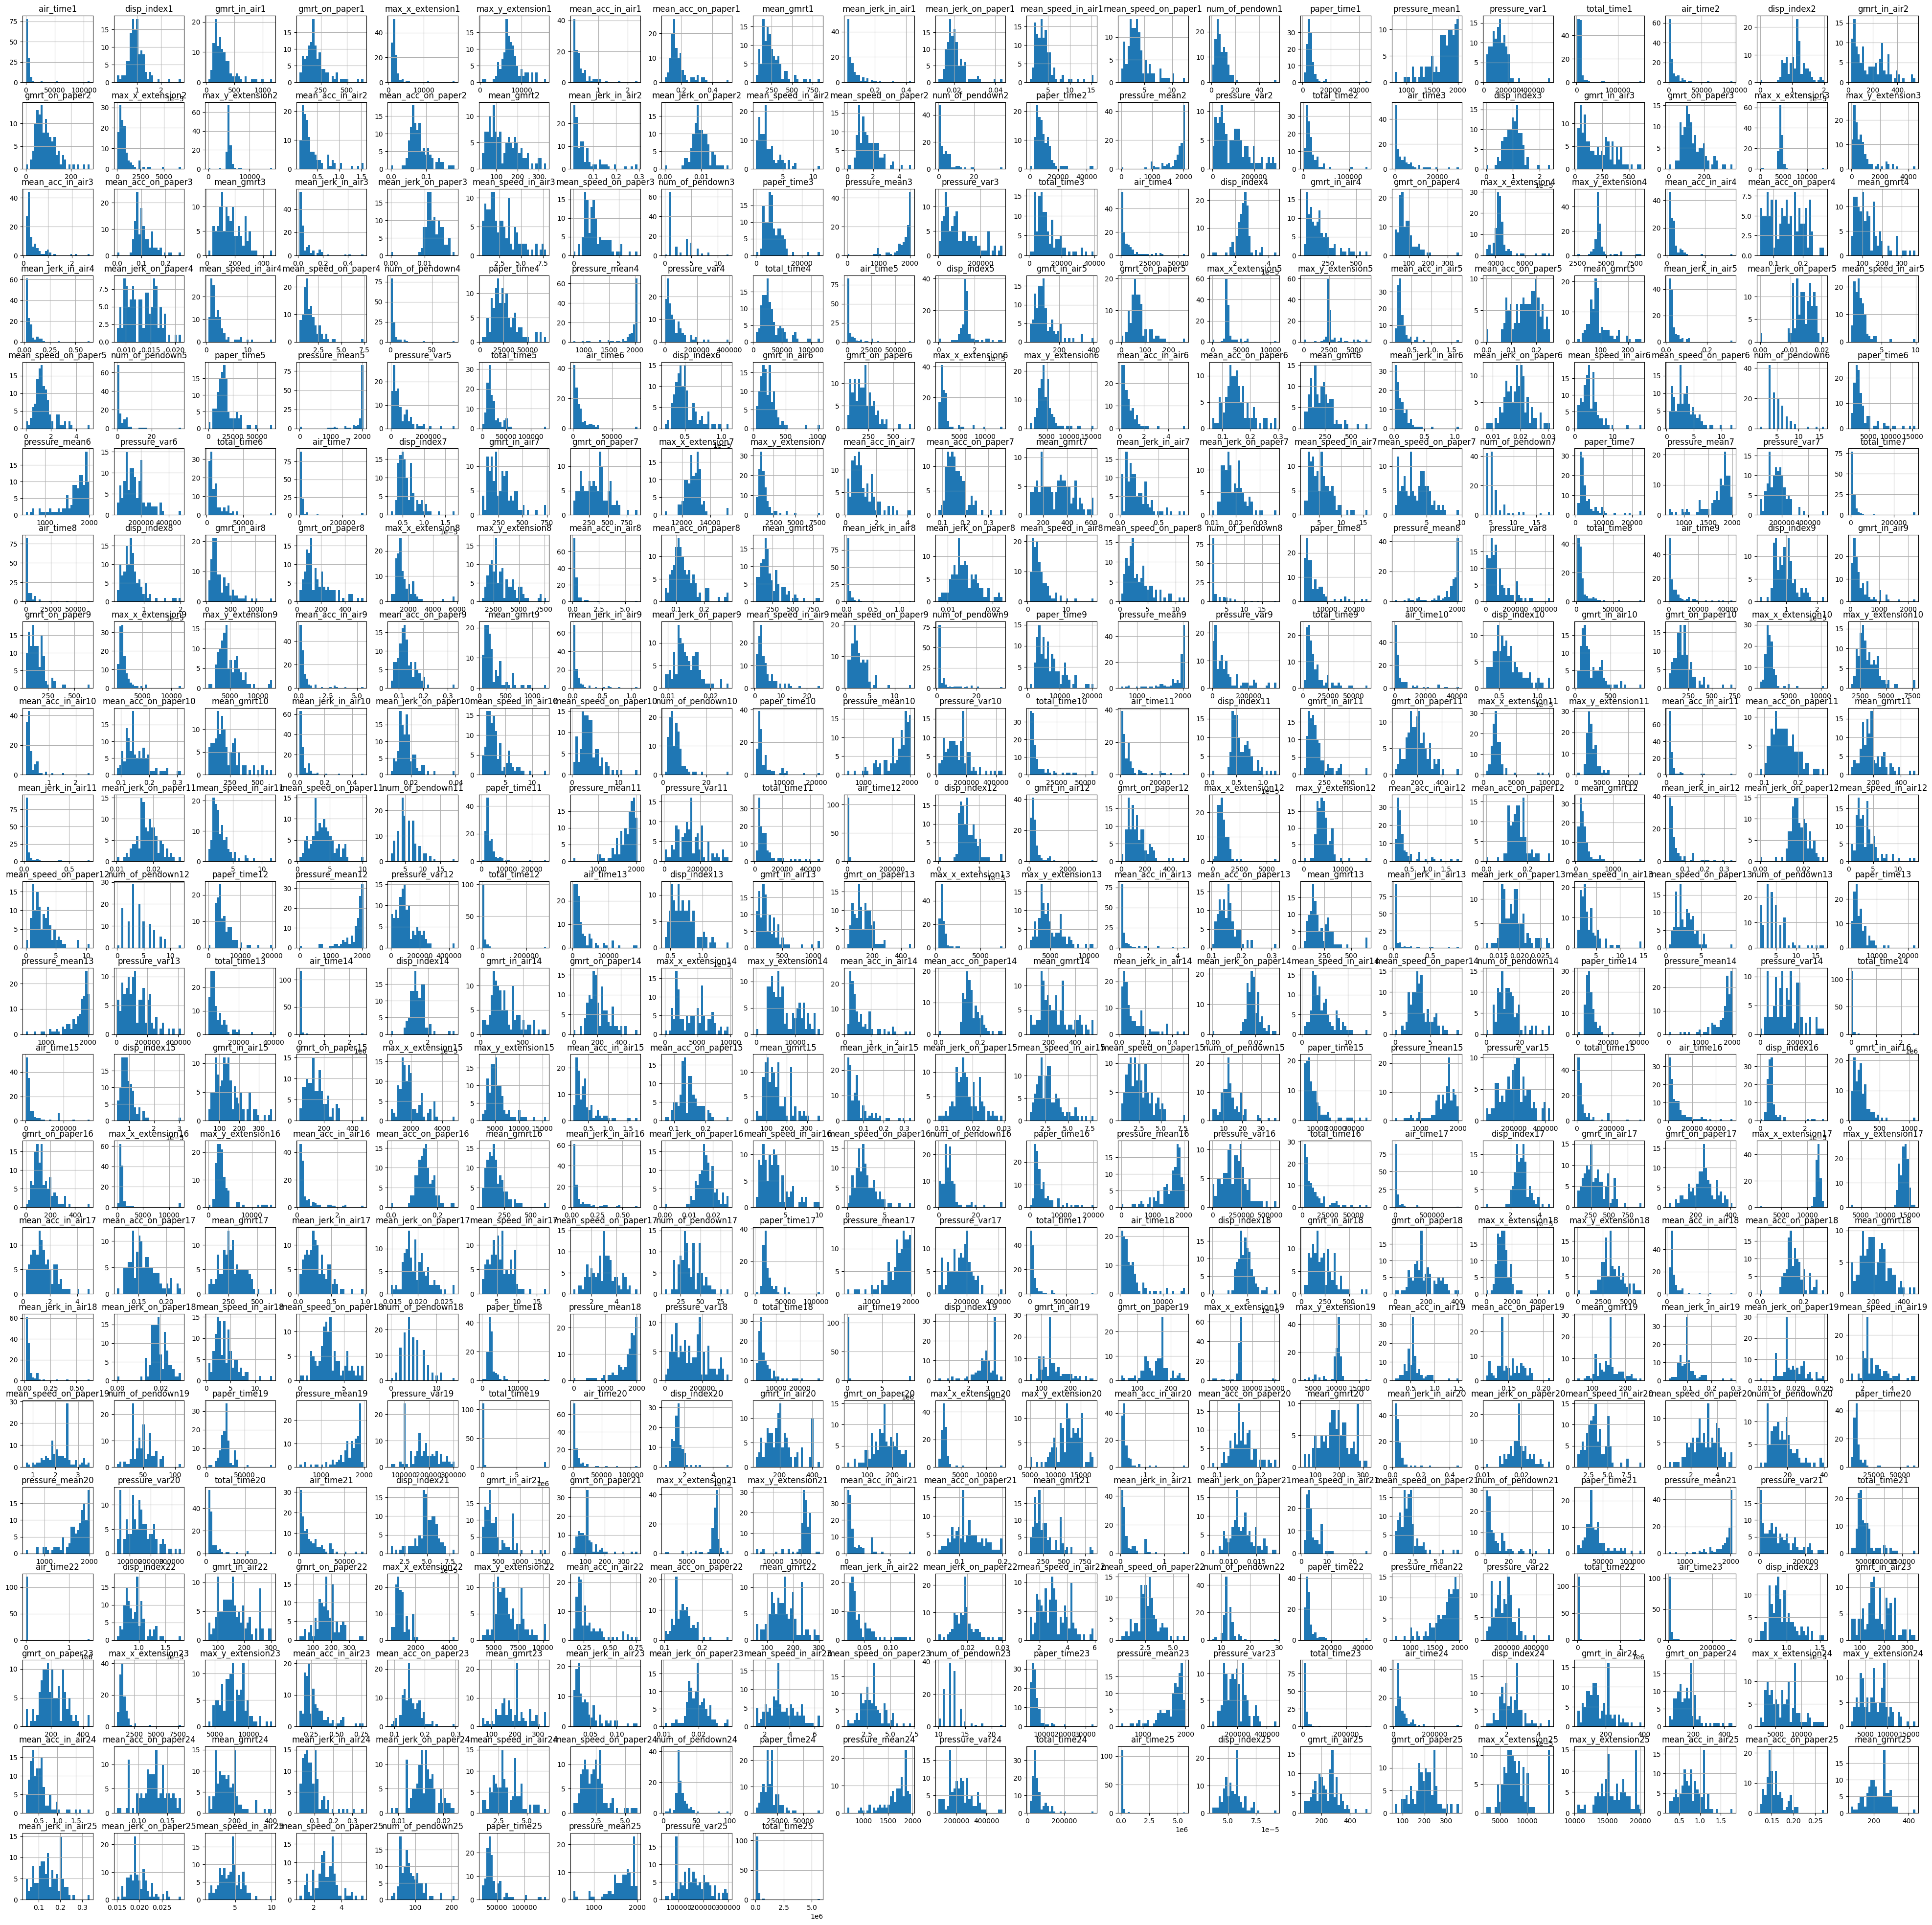

In [6]:
_=df_train.hist(bins=30,figsize=(50,50))

Viendo a primera un histograma de todas las variables, podemos ver que muchas presentan distribución de poisson o exponenciales. Estas últimas podemos aplicarles transformaciones como Yeo-Johnson para intentar que la distribución sea una normal.

In [7]:
# Hacemos test con un 95% confianza
from scipy.stats import normaltest
tanto_por_1_confianza = 0.95
p_v = 1-tanto_por_1_confianza
columns = list(df_train.select_dtypes(include='number').columns)
_ = columns.pop(0)
normal_columns =[]
for column in columns:
    res = normaltest(df_train[column], nan_policy = "omit")
    # si e p_value es menor al p_v significa que rechazamos la hipotesi nula y por lo tanto no sigue una distribución gaussiana
    if(res.pvalue > p_v):
        normal_columns.append(column)
        print(column + " tiene una distribución normal")

disp_index2 tiene una distribución normal
mean_acc_on_paper5 tiene una distribución normal
mean_jerk_on_paper6 tiene una distribución normal
gmrt_on_paper7 tiene una distribución normal
mean_speed_on_paper7 tiene una distribución normal
mean_jerk_on_paper11 tiene una distribución normal
pressure_var14 tiene una distribución normal
mean_jerk_on_paper15 tiene una distribución normal
pressure_var15 tiene una distribución normal
gmrt_on_paper17 tiene una distribución normal
mean_gmrt17 tiene una distribución normal
mean_speed_on_paper17 tiene una distribución normal
pressure_var17 tiene una distribución normal
gmrt_on_paper18 tiene una distribución normal
max_y_extension18 tiene una distribución normal
mean_gmrt18 tiene una distribución normal
mean_speed_on_paper18 tiene una distribución normal
gmrt_on_paper19 tiene una distribución normal
mean_acc_on_paper19 tiene una distribución normal
mean_gmrt19 tiene una distribución normal
mean_jerk_on_paper19 tiene una distribución normal
mean_spee

Aún así tenemos bastantes variables donde si que llegan a presentar una distribución normal, por lo tanto haremos una estandarización en este caso. A continuación haremos la transformaciones de las variables categóricas. 

Como las variables categoricas pueden tener diferentes valores en test y train debido a una posible separación donde no hay elementos compartidos, haremos OneHotEncoding uniendo las tablas y posteriormente separandolas.

In [8]:

union =pd.concat([df_train,df_test])

category_list = list(union.select_dtypes(include=['object']).columns)
for column in category_list:
    dummy = pd.get_dummies(union[column], drop_first=True, prefix=column, prefix_sep='_') * 1
    union = pd.concat([union,dummy], axis=1)
    union.drop(columns=column,inplace=True)

df_train = union.loc[df_train.index,:]
df_test = union.loc[df_test.index,:]



In [9]:
df_train.rename(columns={'class_P': 'Target'}, inplace=True)
df_test.rename(columns={'class_P': 'Target'}, inplace=True)

A continuación comprobamos si hay valores nulos.


In [10]:
df_train.columns[df_train.isna().any()]
df_test.columns[df_test.isna().any()]

Index([], dtype='object')

Index([], dtype='object')

Vemos que no hay valores nulos por lo tanto vamos a pasar directamente a la seleccion de variables. No haremos una busqueda de valores extremos debido a el tamaño tan reducido que tiene el dataset.

(<Figure size 10000x8000 with 1 Axes>, <Axes: >)

<Axes: >

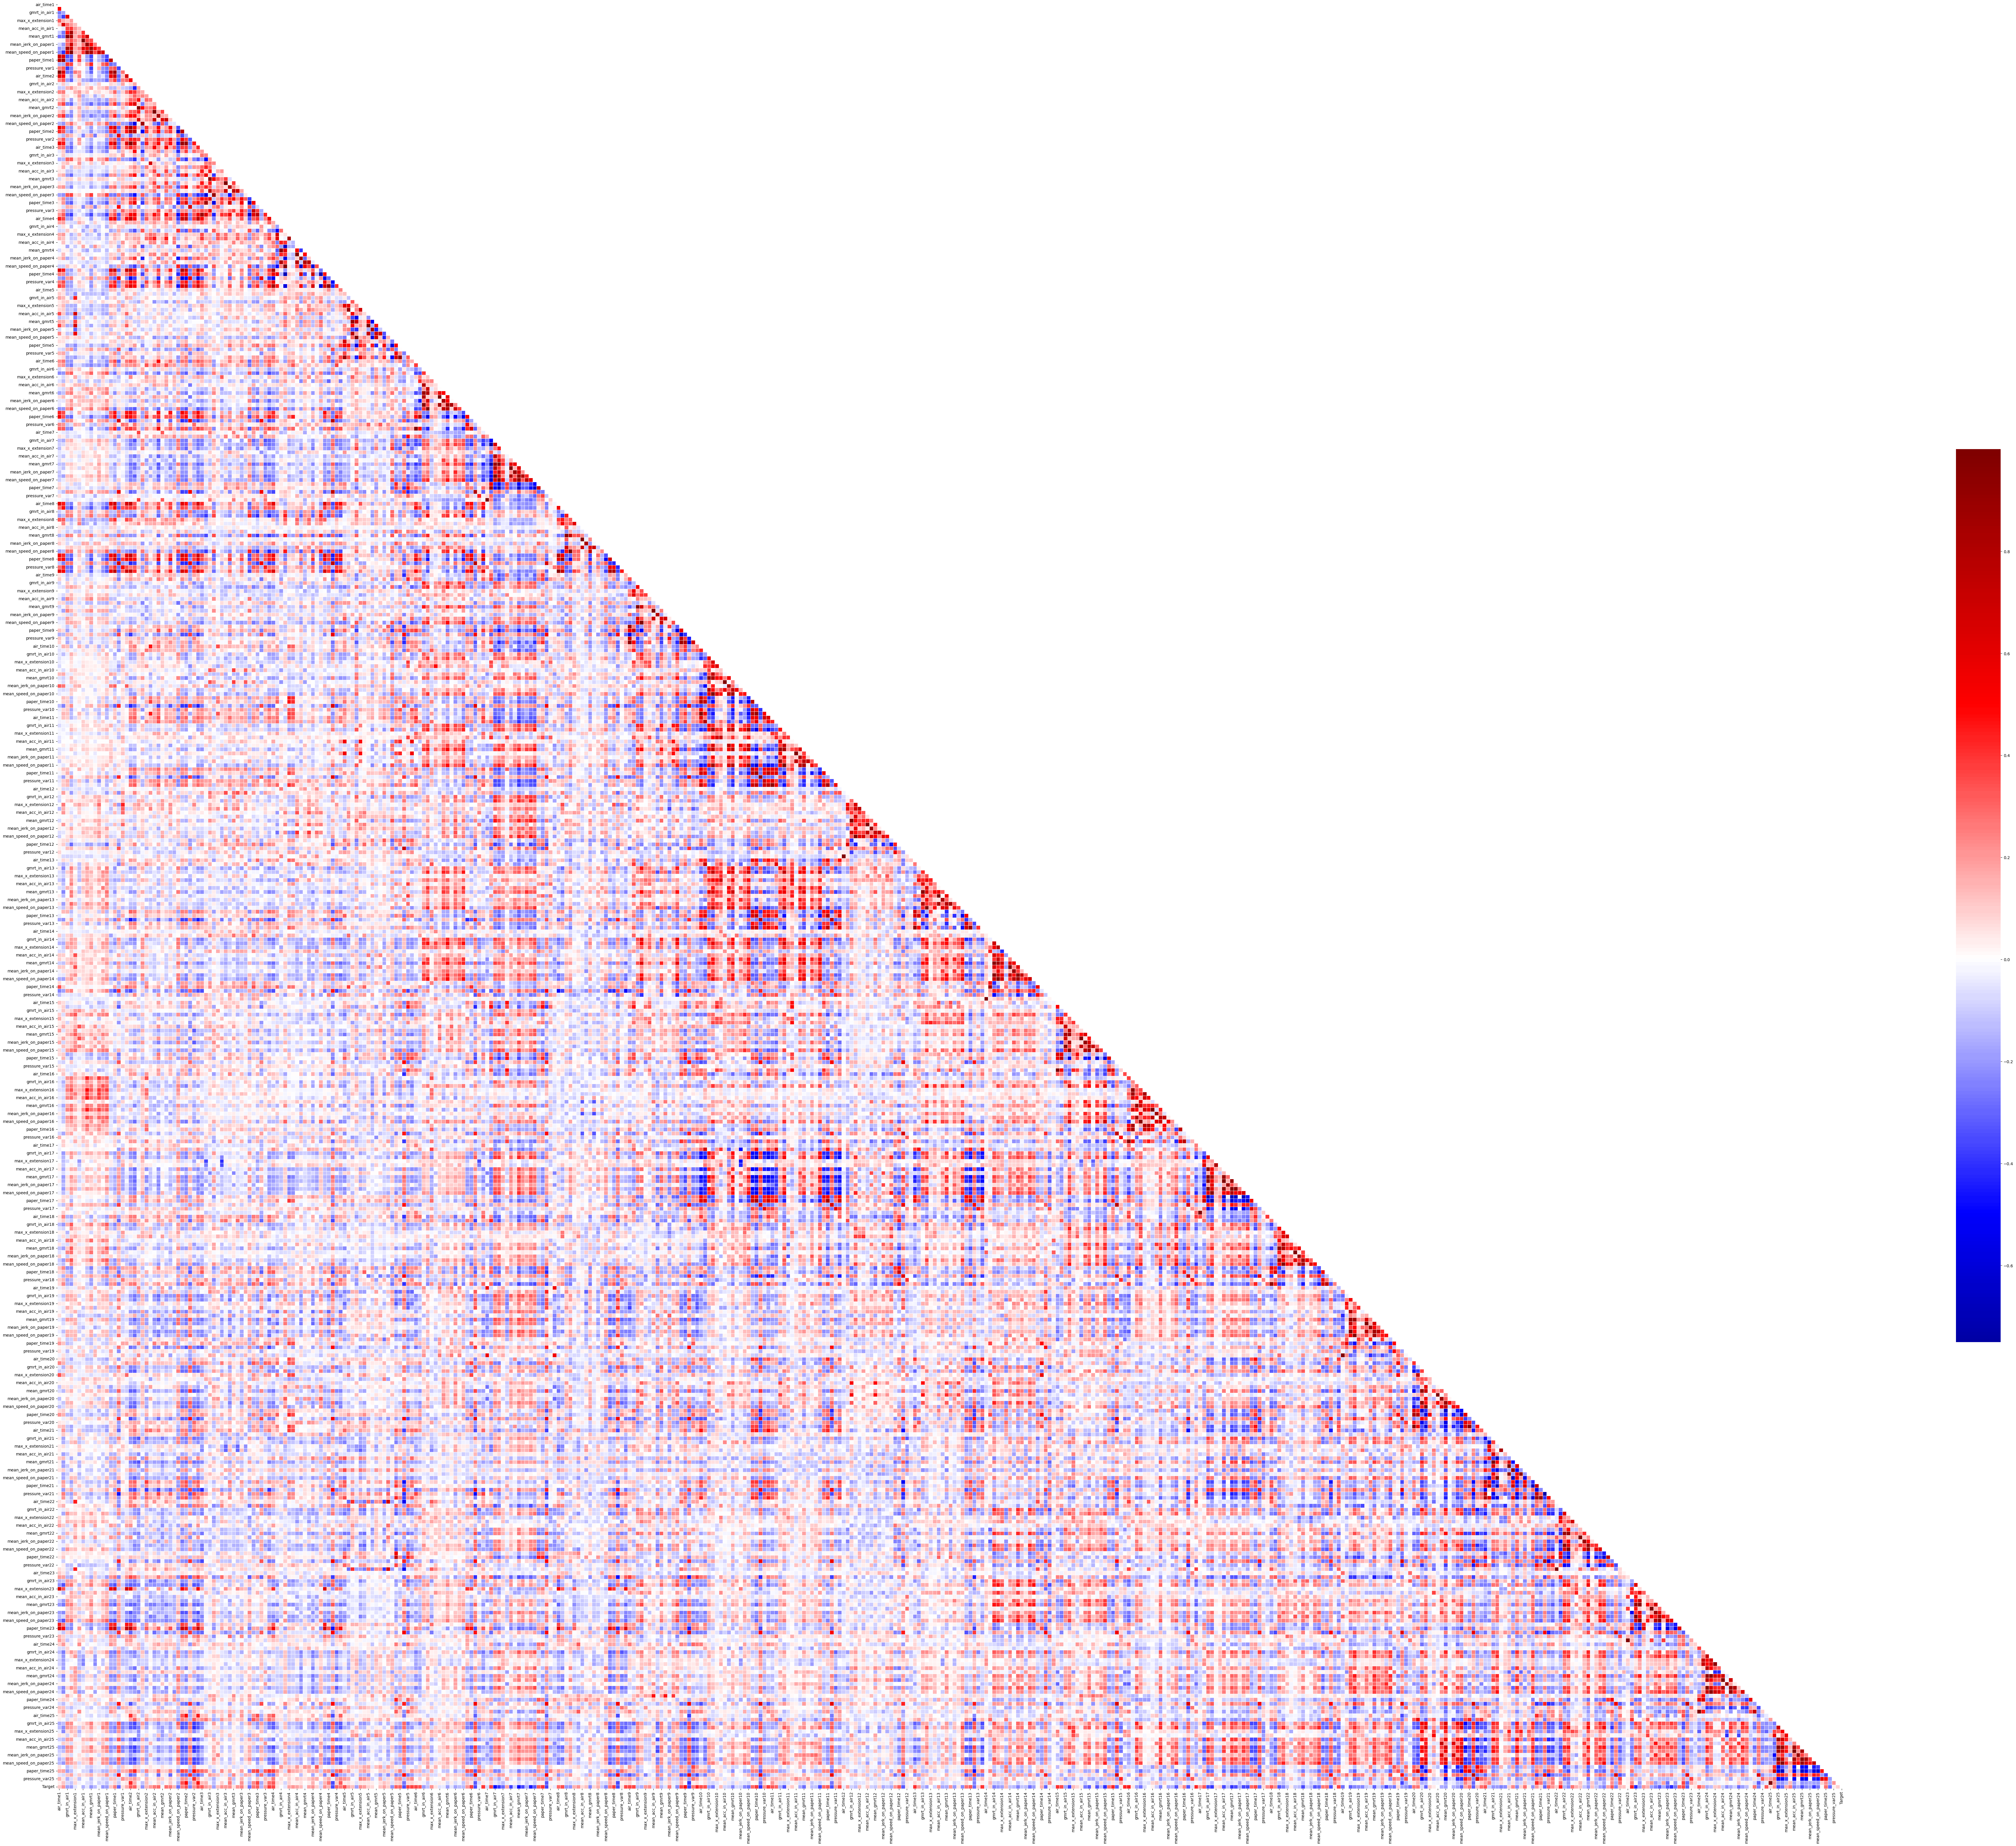

In [11]:
import seaborn as sns
correlaciones = df_train.corr()
mask = np.triu(np.ones_like(correlaciones,dtype = bool))
plt.subplots(figsize=(100,80))
sns.heatmap(correlaciones, mask = mask, cmap="seismic",center = 0, square=True,linewidths=.5, cbar_kws={"shrink": .5})

Debido a la gran cantidad de variables, lo mejor será no eliminar variables a priori. Por lo tanto haremos el paso de normalización. Este lo haremos solamente para los modelos no basados en arboles.

In [12]:
from sklearn.preprocessing import StandardScaler

df_train_no_trees = df_train.copy()
df_test_no_trees =df_test.copy()

scaler = StandardScaler()
scaler.fit(df_train_no_trees.loc[:, normal_columns])
df_train_no_trees.loc[:, normal_columns] = scaler.transform(df_train_no_trees.loc[:, normal_columns])
df_test_no_trees.loc[:, normal_columns] = scaler.transform(df_test_no_trees.loc[:, normal_columns])

StandardScaler()

Para el resto de variables utilizaremos Yeo-Jhonson.

In [13]:
from sklearn.preprocessing import PowerTransformer
not_normal_columns = list(df_train_no_trees.columns.difference(normal_columns))
not_normal_columns.remove("Target")
power_scaler = PowerTransformer(method="yeo-johnson")
power_scaler.fit(df_train_no_trees.loc[:, not_normal_columns])
df_train_no_trees.loc[:, not_normal_columns] = power_scaler.transform(df_train_no_trees.loc[:, not_normal_columns])
df_test_no_trees.loc[:, not_normal_columns] = power_scaler.transform(df_test_no_trees.loc[:, not_normal_columns])

PowerTransformer()

A continuación para tener una base de comparación, utilizaremos naive bayes como modelo de comparación.

In [14]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

In [15]:
X_train_no_tree = df_train_no_trees.copy().drop(columns=["Target"])
X_test_no_tree = df_test_no_trees.copy().drop(columns=["Target"])
y_train_no_tree = df_train_no_trees["Target"]
y_test_no_tree = df_test_no_trees["Target"]

In [16]:
gnb = GaussianNB()
acierto = np.mean(cross_val_score(gnb,X_train_no_tree,y_train_no_tree,cv=7))
print("Acierto medio:",acierto)

Acierto medio: 0.7945845004668532


In [17]:
gnb_model =  GaussianNB().fit(X_train_no_tree,y_train_no_tree)
prediction =gnb_model.predict(X_test_no_tree)
Accuracy_NB = accuracy_score(y_test_no_tree, prediction)
print("Acierto del Naive Bayes aplicado al conjunto de test:", Accuracy_NB)

Acierto del Naive Bayes aplicado al conjunto de test: 0.7924528301886793


In [18]:
print("Informe de Clasificación")
print(classification_report(y_test_no_tree, prediction,target_names=["Healthy", "Patient"]))

Informe de Clasificación
              precision    recall  f1-score   support

     Healthy       0.81      0.79      0.80        28
     Patient       0.77      0.80      0.78        25

    accuracy                           0.79        53
   macro avg       0.79      0.79      0.79        53
weighted avg       0.79      0.79      0.79        53



Vemos que con Naive Bayes obtenemos un recall y precisión para todo los casos. En especial, el caso que queremos evitar son los casos en que se predice que son healthy pero no lo son. Como podemos ver tiene un recall de 0.8 (es decir, ha conseguido identificar a casi todos los paciente Healthy) y una precision similar de 0.77 (es decir, entre todas las predicciones Patient, un 0.77 han sido correctas). A su vez, vemos que f1-score de cada una es bastante elevado y a priori tiene valores aceptables de f1-score.

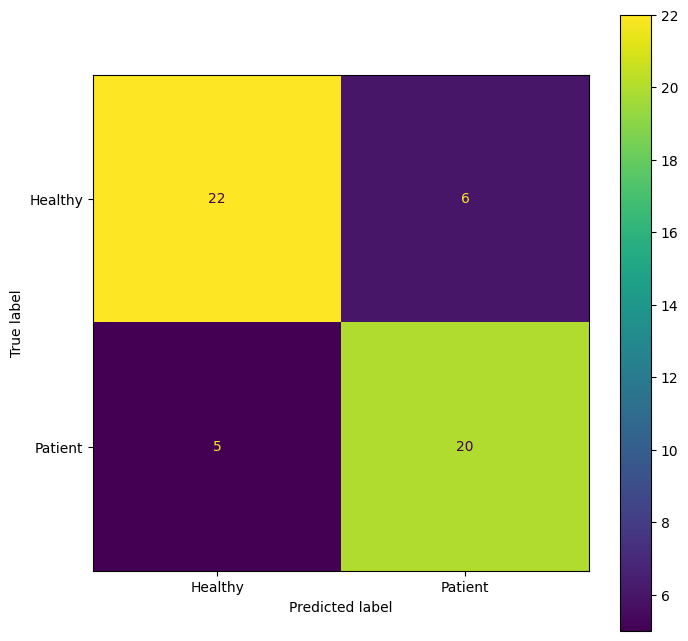

In [19]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_no_tree,y_test_no_tree, display_labels=["Healthy", "Patient"], ax=plt.subplot());

Como podemos observar el caso falso negativo (Patient-Healthy) es el valor más pequeño de todos los mostrados. Únicamente 5 casos mal predichos para el caso que queremos evitar.

## Support Vector Machines

In [20]:
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))
from sklearn.svm import SVC
from skopt import BayesSearchCV
np.int = int

### Kernel lineal

In [21]:
param = {'C':10**np.linspace(-3,3,101),
         'decision_function_shape':['ovo', 'ovr'],
         'gamma':["scale","auto"]}

lsvc = SVC(kernel='linear', max_iter=25000, random_state=0)
lsvc_gs = BayesSearchCV(lsvc,param,n_iter=15, cv=7, n_jobs=-1, refit=True, random_state=0)
lsvc_gs.fit(X_train_no_tree, y_train_no_tree);

/home/jeremy/.local/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [22]:
show_html(pd.DataFrame(lsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
8,"{'C': 0.0034673685045253167, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.884220,1
13,"{'C': 0.0034673685045253167, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.884220,1
14,"{'C': 0.0034673685045253167, 'decision_function_shape': 'ovo', 'gamma': 'auto'}",0.884220,1
0,"{'C': 1.513561248436207, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.876284,4
1,"{'C': 0.03630780547701014, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.876284,4


Podemos ver que obtenemos a primeras estadísticos superiores a Naive Bayes, teniendo valores cercanos a 0.9. A continuación haremos una exploración más a fondo sobre cada posible caso.

In [23]:
prediction =lsvc_gs.predict(X_test_no_tree)
Accuracy_SVM_L = accuracy_score(y_test_no_tree, prediction)
print("Acierto del SVM lineal aplicado al conjunto de test:", Accuracy_SVM_L)

Acierto del SVM lineal aplicado al conjunto de test: 0.8113207547169812


Podemos ver que en cambio sobre el conjunto de test, obtiene un estadístico significativamente menor. Aún así obtiene mejor estadístico que Naive Bayes.

In [24]:
print(classification_report(y_test_no_tree, lsvc_gs.predict(X_test_no_tree), target_names=["Healthy", "Patient"]))

              precision    recall  f1-score   support

     Healthy       0.78      0.89      0.83        28
     Patient       0.86      0.72      0.78        25

    accuracy                           0.81        53
   macro avg       0.82      0.81      0.81        53
weighted avg       0.82      0.81      0.81        53



Vemos que los valores de recall han variado. Concretamente detecta de mejor manera los casos Healthy y de peor manera los casos con Alzheimer. A su vez la precisión en cambio baja para los caso Healthy y sube para los casos con Alzheimer. Esto implica que tiene un gran capacidad de sus predicciones sobre esos casos son muy precisas (ambos tiene valores cercanos a 0.8, un valor aceptable). Si miramos, el f1-score vemos que no han variado significativamente respecto a Naive Bayes, podemos entonces ver que son modelos que se comportan relativamente igual.

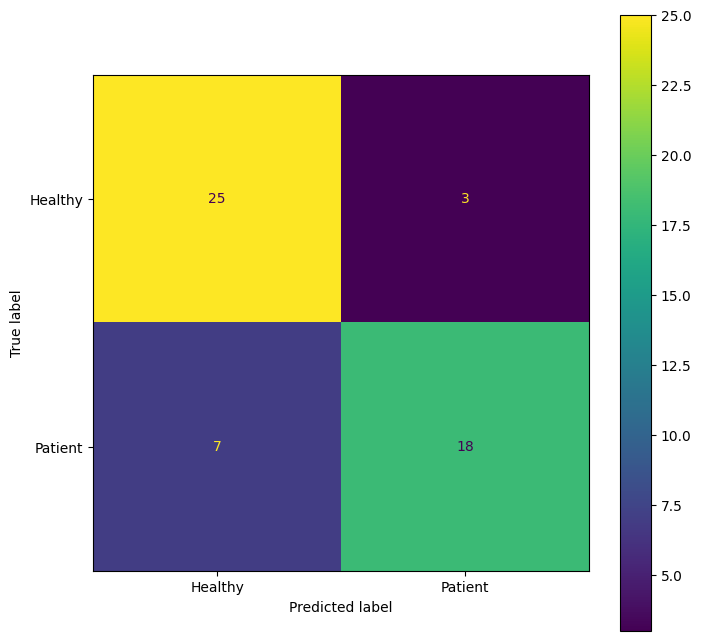

In [25]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvc_gs, X_test_no_tree,y_test_no_tree, display_labels=["Healthy", "Patient"], ax=plt.subplot());

Vemos un incremento en el caso que queremos evitar (Patient-Healthy) respecto Naive Bayes. Por lo tanto, a mi criterio seguiría utilizando el modelo anteriormente mencionado para hacer la predicción.

### VSM Polinómico

In [26]:
param = {'C':10**np.linspace(-3,3,101),
         'decision_function_shape':['ovo', 'ovr'],
         'gamma':["scale","auto"]}

psvc = SVC(kernel='poly', max_iter=25000, random_state=0)
psvc_gs = BayesSearchCV(psvc,param,n_iter=15, cv=7, n_jobs=-1, refit=True, random_state=0)
psvc_gs.fit(X_train_no_tree, y_train_no_tree);

In [27]:
show_html(pd.DataFrame(psvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
7,"{'C': 1.1481536214968828, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.685808,1
0,"{'C': 1.513561248436207, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.677871,2
2,"{'C': 1.513561248436207, 'decision_function_shape': 'ovo', 'gamma': 'auto'}",0.677871,2
5,"{'C': 109.64781961431851, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.661531,4
6,"{'C': 660.6934480075951, 'decision_function_shape': 'ovr', 'gamma': 'auto'}",0.661531,4


Podemos ver que con la versión polinomica obtenemos resultados peores. 

In [28]:

prediction =psvc_gs.predict(X_test_no_tree)
Accuracy_SVM_P = accuracy_score(y_test_no_tree, prediction)
print("Acierto del SVM poly aplicado al conjunto de test:", Accuracy_SVM_P)

Acierto del SVM poly aplicado al conjunto de test: 0.660377358490566


A su vez, vemo que sobre el conjunto de test, obtiene un estadístico menor que su conjunto de training.

In [29]:
print(classification_report(y_test_no_tree, psvc_gs.predict(X_test_no_tree), target_names=["Healthy", "Patient"]))

              precision    recall  f1-score   support

     Healthy       0.61      1.00      0.76        28
     Patient       1.00      0.28      0.44        25

    accuracy                           0.66        53
   macro avg       0.80      0.64      0.60        53
weighted avg       0.79      0.66      0.61        53



Vemos que los valores de recall han variado. El recall de healthy ha sido perfecto pero el que nosotros queríamos aumentar, ha sido el peor. Por lo tanto ya a primeras descartaríamos este modelo ya que hace muy malas predicciones para saber si tienes alzheimer.

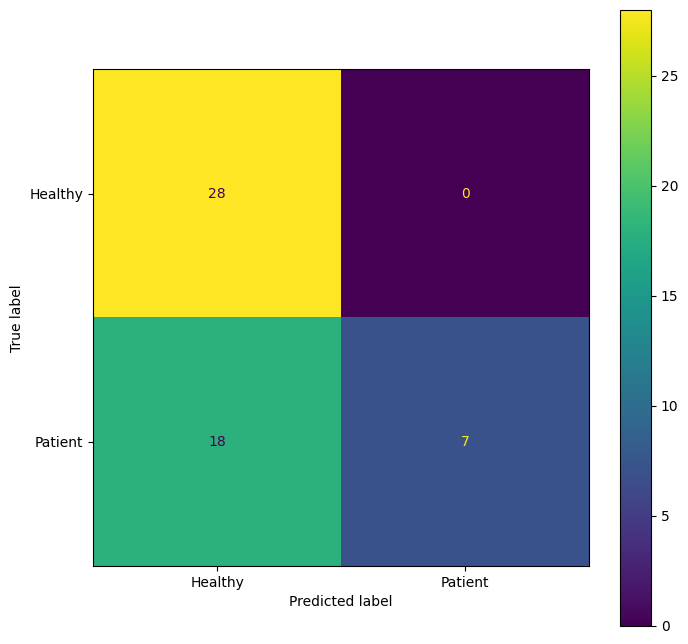

In [30]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(psvc_gs, X_test_no_tree,y_test_no_tree, display_labels=["Healthy", "Patient"], ax=plt.subplot());

Podemos ver que para hay más casos de falso negativo que de verdadero positivo. Concretamente, ese es el caso que queremos evitar por lo tanto, Naive Bayes sigue siendo el modelo que mejor predicciones en nuestro caso da.

### VSM RBF

In [31]:
param = {'C':10**np.linspace(-3,3,101),
         'decision_function_shape':['ovo', 'ovr'],
         'gamma':["scale","auto"]}

rsvc = SVC(kernel='rbf', max_iter=25000, random_state=0)
rsvc_gs = BayesSearchCV(rsvc,param,n_iter=15, cv=7, n_jobs=-1, refit=True, random_state=0)
rsvc_gs.fit(X_train_no_tree, y_train_no_tree);

In [32]:
show_html(pd.DataFrame(rsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
0,"{'C': 1.513561248436207, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.917367,1
2,"{'C': 1.513561248436207, 'decision_function_shape': 'ovo', 'gamma': 'auto'}",0.917367,1
5,"{'C': 109.64781961431851, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.917367,1
6,"{'C': 660.6934480075951, 'decision_function_shape': 'ovr', 'gamma': 'auto'}",0.917367,1
10,"{'C': 7.943282347242813, 'decision_function_shape': 'ovr', 'gamma': 'scale'}",0.917367,1


Usando el Kernel RBF obtenemos los mejores estadísticos hasta el momento. Superando el 0.9, aunque para tener mayor información necesitamos ver el resultado sobre el conjunto de test y ver los casos por separado.

In [33]:

prediction =rsvc_gs.predict(X_test_no_tree)
Accuracy_SVM_RBF = accuracy_score(y_test_no_tree, prediction)
print("Acierto del SVM RBF aplicado al conjunto de test:", Accuracy_SVM_RBF)

Acierto del SVM RBF aplicado al conjunto de test: 0.8301886792452831


Viendo el resultado sobre el conjunto de test podemos ver una disminución en el estadístico de manera significativa respecto al conjunto de training (ha disminuido casi un 0.1).

In [34]:
print(classification_report(y_test_no_tree, rsvc_gs.predict(X_test_no_tree), target_names=["Healthy", "Patient"]))

              precision    recall  f1-score   support

     Healthy       0.81      0.89      0.85        28
     Patient       0.86      0.76      0.81        25

    accuracy                           0.83        53
   macro avg       0.84      0.83      0.83        53
weighted avg       0.83      0.83      0.83        53



Vemos que los valores de de los estadísticos son muy parecidos al kernel lineal. El recall de Patient si que aumenta respecto al modelo mencionado y esto nos ayuda a mejorar el caso que queríamos evitar. Por lo tanto, de los 3 SVM hechos, este es el modelo superior.

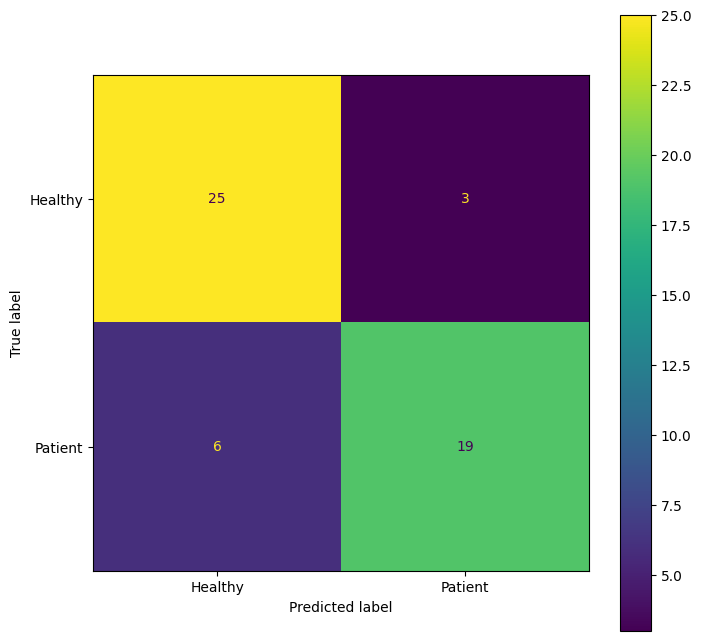

In [35]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rsvc_gs, X_test_no_tree,y_test_no_tree, display_labels=["Healthy", "Patient"], ax=plt.subplot());

Como podemos ver, el caso falso negativo (Patient-Healthy) ha disminuido respecto al Kernel lineal, hecho que estabamos buscando.

### Permutation Importance

In [36]:
from sklearn.inspection import permutation_importance
f1 = permutation_importance(rsvc_gs, X_test_no_tree, y_test_no_tree, n_repeats=20, random_state=0, scoring='f1')
for i in f1.importances_mean.argsort()[::-1]:
    print(f"{X_test_no_tree.columns[i]:<8} "
    f"{f1.importances_mean[i]:.3f}"
            f" +/- {f1.importances_std[i]:.3f}")

max_y_extension24 0.021 +/- 0.010
disp_index19 0.016 +/- 0.014
total_time24 0.009 +/- 0.012
air_time24 0.009 +/- 0.012
max_x_extension24 0.009 +/- 0.012
mean_speed_in_air23 0.006 +/- 0.011
disp_index21 0.006 +/- 0.011
mean_acc_in_air21 0.004 +/- 0.009
disp_index24 0.004 +/- 0.009
air_time13 0.003 +/- 0.008
air_time17 0.003 +/- 0.008
max_y_extension18 0.003 +/- 0.006
mean_jerk_on_paper19 0.002 +/- 0.007
num_of_pendown12 0.002 +/- 0.005
paper_time18 0.002 +/- 0.005
max_x_extension21 0.001 +/- 0.006
gmrt_in_air23 0.001 +/- 0.006
num_of_pendown19 0.001 +/- 0.006
paper_time23 0.001 +/- 0.006
total_time17 0.001 +/- 0.006
mean_acc_on_paper24 0.001 +/- 0.006
mean_jerk_on_paper24 0.001 +/- 0.006
max_y_extension2 0.001 +/- 0.004
mean_jerk_on_paper10 0.001 +/- 0.004
max_x_extension3 0.001 +/- 0.004
mean_jerk_on_paper3 0.001 +/- 0.004
mean_acc_on_paper10 0.001 +/- 0.004
max_y_extension15 0.001 +/- 0.004
mean_jerk_on_paper21 0.001 +/- 0.004
total_time12 0.001 +/- 0.004
mean_jerk_on_paper5 0.001 +/-

Viendo la importancia de las cada feature. Podemos obvservar que este modelo se fija en características en los instantes finales como la extensión en el eje y o el tiempo total.

### Random forest
A continuación debido a la utilización de modelos basados en arboles, utilizaremos el conjunto de datos sin hacer ninguna transformación

In [37]:
df_train_trees = df_train.copy()
df_test_trees =df_test.copy()

In [38]:
X_train_tree = df_train_trees.copy().drop(columns=["Target"])
X_test_tree = df_test_trees.copy().drop(columns=["Target"])
y_train_tree = df_train_trees["Target"]
y_test_tree = df_test_trees["Target"]

In [39]:
from sklearn.ensemble import RandomForestClassifier
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200, 400], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15,30],
         'min_samples_leaf':[1,2,3,5,10]}

rf =  RandomForestClassifier(random_state=0, class_weight={0:1,1:5.5})
rf_cw_bs =  BayesSearchCV(rf,param,n_iter=15, cv=7, n_jobs=-1, refit=True, random_state=0)
rf_cw_bs.fit(X_train_tree, y_train_tree);

In [40]:
show_html(pd.DataFrame(rf_cw_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
9,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}",0.876751,1
3,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 50}",0.868347,2
10,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}",0.859944,3
12,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 50}",0.859477,4
8,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 200}",0.833800,5


Podemos ver que los resultados son superiores a Naive Bayes y muy similares al kernel lineal de los modelos SVM

In [41]:
prediction =rf_cw_bs.predict(X_test_tree)
Accuracy_RF = accuracy_score(y_test_tree, prediction)
print("Acierto de Random Forest aplicado al conjunto de test:", Accuracy_RF)

Acierto de Random Forest aplicado al conjunto de test: 0.8867924528301887


Y vemos que no se ha sobre especializado. Obtenemos estadísticos mejores que con el conjunto de training.

In [42]:
print(classification_report(y_test_tree, rf_cw_bs.predict(X_test_tree), target_names=["Healthy", "Patient"]))

              precision    recall  f1-score   support

     Healthy       0.92      0.86      0.89        28
     Patient       0.85      0.92      0.88        25

    accuracy                           0.89        53
   macro avg       0.89      0.89      0.89        53
weighted avg       0.89      0.89      0.89        53



Vemos que el recall de Patient a mejorado respecto a los modelos SVM y Naive Bayes. Esto nos ayuda a reducir el caso que queremos evitar y a su vez. Viendo el estadístico f1 podemos ver son altos, dando así que el modelo está bastante equilibrado entre precisión y recall.

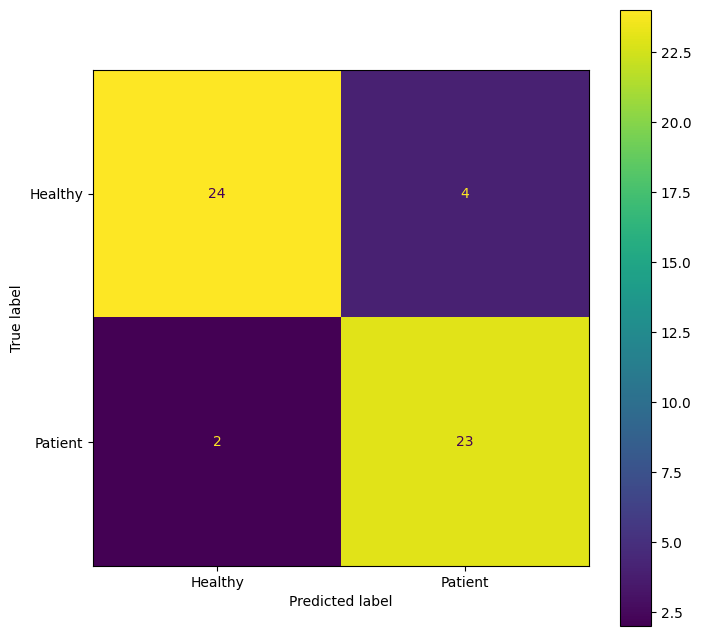

In [43]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rf_cw_bs, X_test_tree,y_test_tree, display_labels=["Healthy", "Patient"], ax=plt.subplot());

Como podemos observar, tenemos solo 6 clasificaciones mal en total y en el caso Patient-Healthy únicamente 2. Esto hace que sea el mejor modelo hasta el momento.

### Gradient Boosting

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss', 'exponential'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=15, cv=7, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train_tree, y_train_tree);

In [45]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
14,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 25}",0.883754,1
10,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 25}",0.875817,2
4,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.867414,3
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.849673,4
11,"{'criterion': 'squared_error', 'learning_rate': 3.0, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 25}",0.801120,5


Viendo los resultado de Gradient Boosting, podemos observar que son superiores a Naive Bayes pero no superiores a Random Forest.

In [46]:
prediction =gb_bs.predict(X_test_tree)
Accuracy_GB = accuracy_score(y_test_tree, prediction)
print("Acierto de Random Boosting aplicado al conjunto de test:", Accuracy_GB)

Acierto de Random Boosting aplicado al conjunto de test: 0.8113207547169812


Si lo aplicamos sobre test si que podemos ver un descenso similar a los obtenidos con el kernel lineal del modelo hecho con SVM.

In [47]:
print(classification_report(y_test_tree, gb_bs.predict(X_test_tree), target_names=["Healthy", "Patient"]))


              precision    recall  f1-score   support

     Healthy       0.78      0.89      0.83        28
     Patient       0.86      0.72      0.78        25

    accuracy                           0.81        53
   macro avg       0.82      0.81      0.81        53
weighted avg       0.82      0.81      0.81        53



Viendo el informe de clasificación vemos que identico al kernel lineal SVM. Por lo tanto, el mejor modelo de esta sección es el modelo Random Forest.

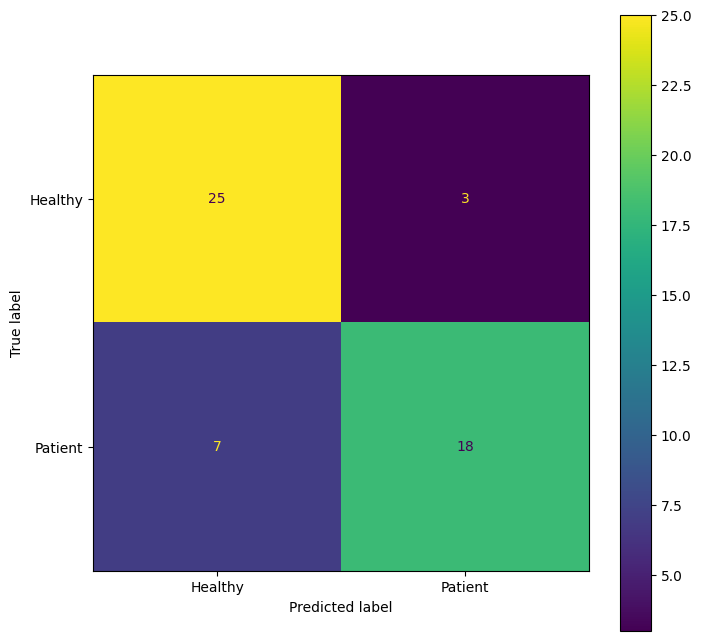

In [48]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gb_bs, X_test_tree,y_test_tree, display_labels=["Healthy", "Patient"], ax=plt.subplot());

### Permutation Importance

In [49]:
f1 = permutation_importance(rf_cw_bs, X_test_tree, y_test_tree, n_repeats=20, random_state=0, scoring='f1')
for i in f1.importances_mean.argsort()[::-1]:
    print(f"{X_test_tree.columns[i]:<8} "
    f"{f1.importances_mean[i]:.3f}"
            f" +/- {f1.importances_std[i]:.3f}")

total_time17 0.030 +/- 0.015
disp_index19 0.028 +/- 0.014
num_of_pendown19 0.024 +/- 0.017
gmrt_in_air11 0.023 +/- 0.015
total_time2 0.022 +/- 0.017
max_x_extension24 0.021 +/- 0.015
air_time24 0.021 +/- 0.011
pressure_mean13 0.021 +/- 0.005
max_y_extension19 0.020 +/- 0.011
mean_acc_on_paper9 0.020 +/- 0.016
pressure_var1 0.020 +/- 0.014
mean_acc_on_paper2 0.019 +/- 0.008
disp_index25 0.018 +/- 0.015
mean_speed_in_air23 0.018 +/- 0.015
total_time23 0.018 +/- 0.015
total_time24 0.018 +/- 0.011
mean_jerk_on_paper21 0.018 +/- 0.011
mean_speed_in_air17 0.017 +/- 0.009
air_time5 0.017 +/- 0.009
total_time25 0.016 +/- 0.012
pressure_var19 0.016 +/- 0.009
gmrt_on_paper17 0.016 +/- 0.009
pressure_mean2 0.016 +/- 0.009
max_y_extension24 0.016 +/- 0.009
paper_time10 0.016 +/- 0.015
air_time23 0.016 +/- 0.017
mean_jerk_in_air23 0.015 +/- 0.014
gmrt_in_air17 0.015 +/- 0.010
paper_time19 0.015 +/- 0.010
air_time17 0.015 +/- 0.010
mean_jerk_on_paper24 0.015 +/- 0.010
pressure_mean11 0.015 +/- 0.010

Viendo los pesos, vemos que se fija principalmente en estadísticas de los instantes finales, a su vez que se fija en el tiempo que transcurre cada acción (se fija en las variables total_time), asi como también las diferentes presiones.

### Arbol de decisión

A continuación haremos el modelo basado en arbol de decisión.


In [84]:
from sklearn.tree import DecisionTreeClassifier
param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13],
         'min_samples_leaf':[1,2,3,5,10,20], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30,40]}

dt =  DecisionTreeClassifier(random_state=0)
dt_bs =  BayesSearchCV(dt,param,n_iter=15, cv=7, n_jobs=-1, refit=True, random_state=0)
dt_bs.fit(X_train_tree.values, y_train_tree);

In [85]:
show_html(pd.DataFrame(dt_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
9,"{'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'splitter': 'best'}",0.768441,1
14,"{'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 5, 'min_samples_leaf': 10, 'splitter': 'best'}",0.768441,1
10,"{'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'splitter': 'random'}",0.759570,3
13,"{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'splitter': 'random'}",0.759570,3
0,"{'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'splitter': 'random'}",0.758637,5


Vemos a primeras que el mejor modelo basado en arboles de decision no llega a ser mejor que Naive Bayes en el conjunto de training.

In [86]:
prediction =dt_bs.predict(X_test_tree)
Accuracy_dt = accuracy_score(y_test_tree, prediction)
print("Acierto de Arbol de decision aplicado al conjunto de test:", Accuracy_dt)

Acierto de Arbol de decision aplicado al conjunto de test: 0.7924528301886793


/home/jeremy/.local/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names


Pero obtiene mejor resultado con el conjunto de test, dando a entender que el modelo no se ha sobrespecializado.

In [87]:
print(classification_report(y_test_tree, dt_bs.predict(X_test_tree), target_names=["Healthy", "Patient"]))

              precision    recall  f1-score   support

     Healthy       0.77      0.86      0.81        28
     Patient       0.82      0.72      0.77        25

    accuracy                           0.79        53
   macro avg       0.80      0.79      0.79        53
weighted avg       0.79      0.79      0.79        53



/home/jeremy/.local/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names


Si miramos el informe de clasificación, vemos que se tiene valores similares al modelo SVM lineal.

/home/jeremy/.local/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names


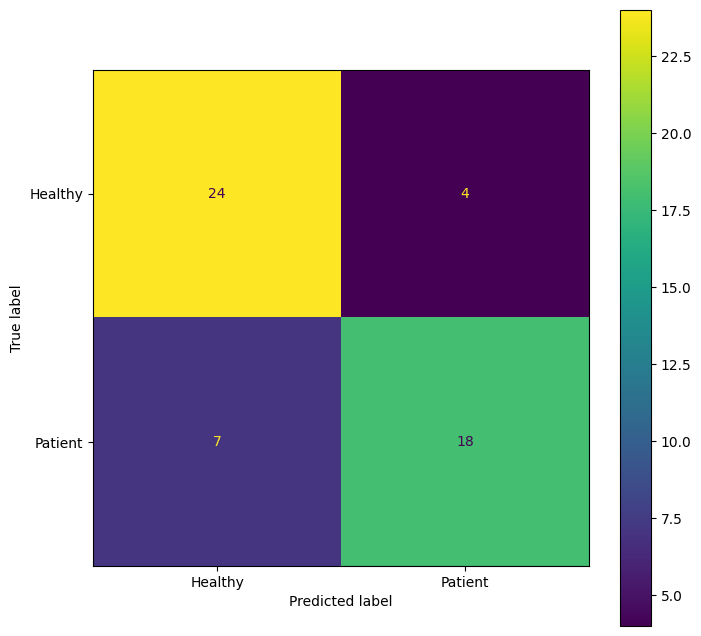

In [93]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_bs, X_test_tree,y_test_tree, display_labels=["Healthy", "Patient"], ax=plt.subplot());

Si comparamos estos valores con modelos anteriores como el Kernel lineal de SVM o Gradient Boosting, vemos clasifica de manera similar los caso de Patient. Es decir, tanto Patient-Healthy como Patient-Patient tiene mismos valores. En cambio, en el caso Healthy es inferior ya que clasifica mal una persona más comparando con los modelos mencionados. Esto se ve en los valores del apartado Healthy del informe de clasificación (tanto el recall como la precisión hacen una pequeña disminución). A partir de estos hechos, el mejor modelo es Random Forest porque logra clasificar a la perfección casi todos los ejemplares.

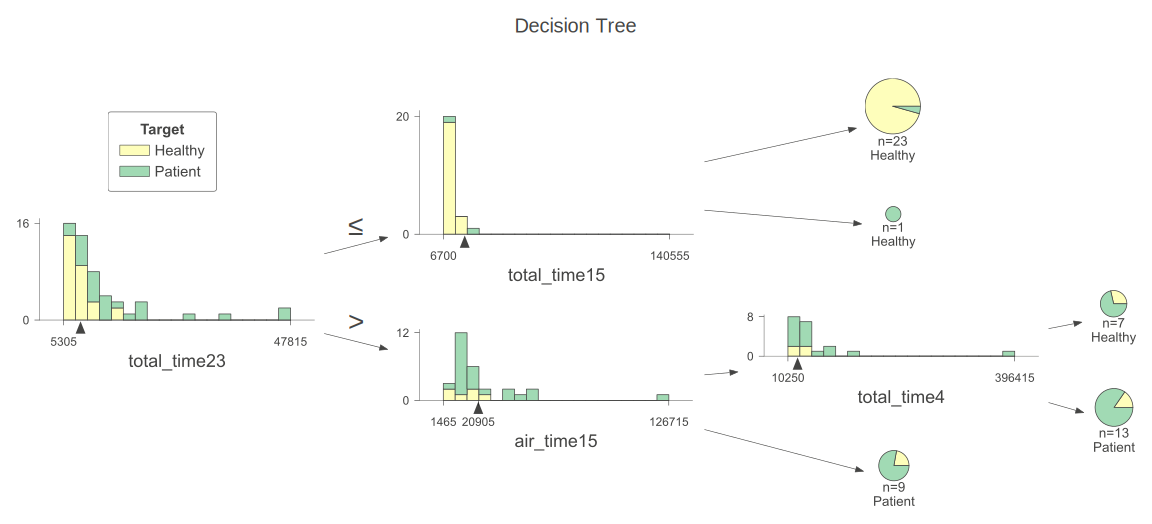

In [97]:
import dtreeviz
v_model = dtreeviz.model(dt_bs.best_estimator_, 
               X_train=X_test_tree,
               y_train=y_test_tree,
               target_name='Target',
               feature_names=list(X_train_tree.columns),
               class_names=["Healthy", "Patient"]
               )
v_model.view(scale=2, title="Decision Tree",orientation='LR')

Si hacemos una comparació del arbol de decisión del modelo y el permutation importance vemos que no tienen mucha correlación entre ellas. Lo que podemos decir, es que las permutation importance si que pone importancia a columnas como el total_time en los tiempos finales del muestreo. En cambio, el arbol de decisión se fija en en el tiempo total al final, medio y principio de la muestra. A su vez, en el arbol vemos que se fija en el air_time15 mientras que los demás ponen importancia a air_time24. Es diferente el instante pero podemos decir que el tiempo que está en el aire es importante para entender el modelo. 

Para acabar, quiero remarcar que el mejor modelo es el Random Forest porque consigue clasificar casi de manera perfecta todos los ejemplares y ofrece baja tasa de fallo en el caso Patient, que es el caso que quiero evitar dar falsas clasificaciones.